<a href="https://colab.research.google.com/github/DrYGuo/Defect-detection-in-atomic-resolution-image-via-unsupervised-learning-with-translational-invariance/blob/main/OneClass_SVM_for_image_stacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load modules

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import dm3_lib
import skimage.feature
from matplotlib.patches import Circle
import matplotlib.colors
import scipy.ndimage
#from numba import jit
from collections import namedtuple
!pip install scikit-image
import json

Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls /content/drive/Shared\ drives/

TMD_NIST


In [ ]:
path='/content/drive/Shareddrives/TMD_NIST/data/Bilayer 2H MoW0.09Te2 nice images/Recording of SuperScan (a)img_stack.ndata1'

In [ ]:
# path='/content/drive/Shareddrives/TMD_NIST/data/Bilayer 2H MoW0.09Te2 nice images/Filter of FFT of Recording of SuperScan (a)_image_stack.ndata1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_zipped=np.load(path)
#data=data_zipped['data'][:,30:] # remove the left margin with flyback error 
data=data_zipped['data']
metadata=data_zipped['metadata.json']
print(metadata)
scalebar=json.loads(metadata)['spatial_calibrations'][0]['scale']
print(scalebar)
data.shape

b'{"version": 1, "reader_version": 1, "large_format": true, "spatial_calibrations": [{"offset": 0.0, "scale": 1.0, "units": ""}, {"offset": -4.0, "scale": 0.015625, "units": "nm"}, {"offset": -4.0, "scale": 0.015625, "units": "nm"}], "intensity_calibration": {"offset": 0.0, "scale": 1.0, "units": ""}, "is_sequence": true, "collection_dimension_count": 0, "datum_dimension_count": 2, "metadata": {"instrument": {"high_tension": 60000.0, "defocus": 3.8887933688656534e-10, "ImageScanned": {"C1 ConstW": 0.535, "C10": 3.8887933688656534e-10, "C10Control": 0.0, "C12.a": 3.6374544277865037e-09, "C12.b": -3.313156584860766e-10, "C2 ConstW": 0.759, "C21.a": 2.2903045371024158e-07, "C21.b": 1.212278697586901e-07, "C23.a": 3.2398480972919405e-08, "C23.b": 4.1505043101378426e-08, "C3 ConstW": 0.971829, "C30": 1.9803564077052478e-06, "C32.a": 6.1606683130164315e-06, "C32.b": 3.988842788800432e-06, "C34.a": 2.8415469546947416e-06, "C34.b": 1.9483854869111876e-06, "C41.a": -0.0003642179172182993, "C41.

(100, 512, 512)

In [ ]:
nth_frame=data.shape[0]
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def F(i):
  plt.imshow(data[i,:,:],cmap='gray',vmax=0.5,vmin=0.0)
  plt.colorbar()

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

Smooth and normalize the image

In [ ]:
plt.set_cmap('Greys_r')

<Figure size 432x288 with 0 Axes>

In [ ]:
import scipy
# YG_data=scipy.ndimage.gaussian_filter(data,sigma=2)

def Smooth_normalize(data):
    """
    smooth and normalize data
    """
    frames,rows,cols=data.shape
    YG_data=np.zeros((frames,rows,cols))
    for frame in np.arange(frames):
        image=scipy.ndimage.gaussian_filter(data[frame,:,:],sigma=1.5)
        YG_data[frame,:,:]=(image - np.amin(image)) / (np.amax(image) - np.amin(image)) 

    return YG_data

YG_data_norm=Smooth_normalize(data)

In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def F(i):
  plt.imshow(YG_data_norm[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  # plt.colorbar()
  plt.axis('off')

interactive_plot = interactive(F, i=(0, nth_frame-1))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

invert the contrast for hole finder

In [ ]:
frames,rows,cols=data.shape
YG_data=np.zeros((frames,rows,cols))
for frame in np.arange(frames):
    image=scipy.ndimage.gaussian_filter(data[frame,:,:],sigma=2.5)
    YG_data[frame,:,:]=(image - np.amin(image)) / (np.amax(image) - np.amin(image)) 

data_inverted=np.ones((data.shape[0],data.shape[1],data.shape[1]))-YG_data
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def F(i):
  plt.imshow(data_inverted[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  plt.colorbar()

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

Hole finder

In [ ]:
from skimage.feature import peak_local_max
xy=[]
for frame in np.arange(data.shape[0]):
   xy_peaks= peak_local_max(data_inverted[frame,:,:], min_distance=5,threshold_abs=0.50)
   for i in np.arange(xy_peaks.shape[0]):
      xy.append([frame,xy_peaks[i,0],xy_peaks[i,1]])
xy=np.array(xy)
print(xy.shape)

(65301, 3)


In [ ]:
# print(xy)
print(xy[np.where(xy[:,0]==99)])

[[ 99 506 369]
 [ 99 506 221]
 [ 99 506 112]
 ...
 [ 99   6 134]
 [ 99   6  97]
 [ 99   6  60]]


In [ ]:
# data_inverted=np.ones((data.shape[0],data.shape[1],data.shape[1]))-YG_data_norm
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(YG_data_norm[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  plt.scatter(xy[np.where(xy[:,0]==i)][:,2],xy[np.where(xy[:,0]==i)][:,1])
  plt.colorbar()

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

atom finder

In [ ]:
from skimage.feature import peak_local_max
xy2=[]
for frame in np.arange(data.shape[0]):
   xy2_peaks= peak_local_max(YG_data_norm[frame,:,:], min_distance=4,threshold_abs=0.10)
   for i in np.arange(xy2_peaks.shape[0]):
      xy2.append([frame,xy2_peaks[i,0],xy2_peaks[i,1]])
xy2=np.array(xy2)
print(xy2.shape)

(130947, 3)


In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(YG_data_norm[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  plt.scatter(xy2[np.where(xy2[:,0]==i)][:,2],xy2[np.where(xy2[:,0]==i)][:,1])
  plt.colorbar()

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

Hole coordinates refinement

create a mask

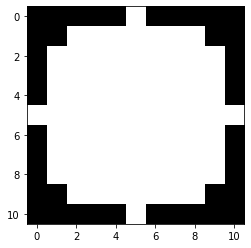

In [ ]:
import math

wind_size2=11

mask_circle=np.zeros((wind_size2,wind_size2))

h,w=mask_circle.shape
y_center=math.floor(h/2)
x_center=math.floor(w/2)
mask=np.zeros((h,w))

r_crit=math.floor(h/2)


for i in np.arange(w):
   for j in np.arange(h):
     if (i-x_center)**2 + (j-y_center)**2 <=r_crit**2:
        mask[i,j]=1

plt.imshow(mask)

In [ ]:
xy2_refined=xy2.copy()

In [ ]:
data_inverted.shape

(100, 512, 512)

In [ ]:
xy_refined=xy.copy()

count=0
for frame in np.arange(data_inverted.shape[0]):
  for jj,x_y in enumerate(xy[np.where(xy[:,0]==frame)]):
    x=x_y[1]
    y=x_y[2]
    if x-5>=0 and x+6<=data_inverted.shape[1]-1 and y-5>=0 and y+6<=data_inverted.shape[2]-1:
      data2_area_max=np.sum(np.sum(data_inverted[frame,x-5:x+6,y-5:y+6]*mask))
      data2_area_max_init=data2_area_max
      for i in np.arange(-4,4,1):
        for j in np.arange(-4,4,1):
          if (x-5+i)>=0 and x+6+i<=data_inverted.shape[1]-1 and y-5+j>=0 and y+6+j<=data_inverted.shape[2]-1: #if the area is not beyond the edge
            masked_area=data_inverted[frame,x-5+i:x+6+i,y-5+j:y+6+j]*mask
            if np.sum(np.sum(masked_area))>data2_area_max:
              data2_area_max=np.sum(np.sum(masked_area))
              xy_refined[count+jj,1]=x+i
              xy_refined[count+jj,2]=y+j
      # if data2_area_max!=data2_area_max_init: # if the refined coordinates are different from the original xy2
      #   print(jj,data2_area_max,xy_refined[count+jj,0],xy_refined[count+jj,1])
      #   print(jj,np.sum(np.sum(YG_data_norm[frame,x-5:x+6,y-5:y+6]*mask)),x,y)
  
  count=count+xy[np.where(xy[:,0]==frame)].shape[0]
  print(frame)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(YG_data_norm[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  plt.scatter(xy_refined[np.where(xy_refined[:,0]==i)][:,2],xy_refined[np.where(xy_refined[:,0]==i)][:,1])
  # plt.colorbar()

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

Create a sematic image with each atom having the same Gaussian distribution

8
2D Gaussian-like array:
(17, 17)


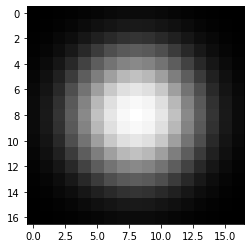

In [ ]:
# create a 2d Gaussian distribution
atom_size=17
r_atom=math.floor(atom_size/2)
print(r_atom)

x, y = np.meshgrid(np.linspace(-1,1,atom_size), np.linspace(-1,1,atom_size))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.4, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
print("2D Gaussian-like array:")
print(g.shape)
plt.imshow(g)

In [ ]:
xy2_refined=xy2.copy()
print(xy2_refined.shape)

(130947, 3)


In [ ]:
xy2_refined

array([[  0, 507, 303],
       [  0, 507, 230],
       [  0, 507, 181],
       ...,
       [ 99,   6,  39],
       [ 99,   5,  74],
       [ 99,   5,  13]])

In [ ]:
semantic_image=np.zeros((YG_data_norm.shape[0],YG_data_norm.shape[1],YG_data_norm.shape[2]))

for frame in np.arange(YG_data_norm.shape[0]):
  for j,x_y in enumerate(xy2_refined[np.where(xy2_refined[:,0]==frame)]):
       x=x_y[1]
       y=x_y[2]
       if x-r_atom>0 and x+r_atom+1<=semantic_image.shape[1]-1 and y-r_atom>0 and y+r_atom+1<=semantic_image.shape[2]-1:
         semantic_image[frame,x-r_atom:x+r_atom+1,y-r_atom:y+r_atom+1]=g+semantic_image[frame,x-r_atom:x+r_atom+1,y-r_atom:y+r_atom+1]
      # if (x,y) in V_positions: 
      #   semantic_image[x-r_atom:x+r_atom+1,y-r_atom:y+r_atom+1]=-0.3*g+semantic_image[x-r_atom:x+r_atom+1,y-r_atom:y+r_atom+1]


In [ ]:
def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(semantic_image[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  plt.scatter(xy_refined[np.where(xy_refined[:,0]==i)][:,2],xy_refined[np.where(xy_refined[:,0]==i)][:,1])
  # plt.colorbar()

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

Prepare datasets for training

In [ ]:
#expdata=YG_data_norm.copy()
expdata=semantic_image.copy()
size_subimages=37

In [ ]:
def normalize_image(image):
    """
    Normalizes the provided image from 0 to 1
    """
    return (image - np.amin(image)) / (np.amax(image) - np.amin(image))

This following cell is very time consuming (it can take more than 0.5h). Skip this to the next cell and download the result for this step.

In [ ]:
collection=np.zeros((size_subimages,size_subimages,1))
coord_collection=np.zeros((1,3))
for frame in np.arange(YG_data_norm.shape[0]):
  for i,x_y in enumerate(xy_refined[np.where(xy_refined[:,0]==frame)]):
    y1=int(x_y[1]-size_subimages/2)
    y2=y1+size_subimages
    x1=int(x_y[2]-size_subimages/2)
    x2=x1+size_subimages
    if y1>=30 and y2<=YG_data_norm.shape[1]-30 and x1>=30 and x2<=YG_data_norm.shape[2]-30:
      subimage_i=normalize_image(expdata[frame,y1:y2,x1:x2])
      collection=np.append(collection, np.atleast_3d(subimage_i), axis=2)
      row=x_y[1]
      col=x_y[2]
      coord_collection=np.vstack([coord_collection,[frame,row,col]])
  print(frame)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
new_collection=np.delete(collection, 0, axis=2)
new_coord_collection=np.delete(coord_collection,0,axis=0)

In [ ]:
np.savez('dataset_for_100frames_2',new_collection,new_coord_collection)

In [ ]:
from google.colab import files
files.download('dataset_for_100frames_2.npz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load previously saved dataset ()

In [ ]:
new_coord_collection.shape
new_collection.shape

(37, 37, 44918)

(44918, 37, 37)
(44918, 1369)


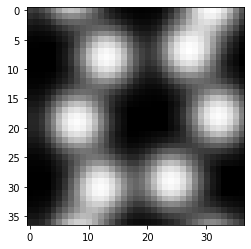

In [ ]:
img_stack_init=new_collection.transpose(2,0,1)
plt.imshow(img_stack_init[8,:,:])
print(img_stack_init.shape)
img_stack_init_flat=img_stack_init.reshape(img_stack_init.shape[0],img_stack_init.shape[1]*img_stack_init.shape[2])
print(img_stack_init_flat.shape)

Patterson function by convolution

In [ ]:
import scipy.signal
def Patterson_function2(image):
   image_invert=np.fliplr(np.flipud(image))
   output=scipy.signal.convolve2d(image,image_invert,mode='same',boundary='wrap')
   return output

In [ ]:
img_stack=[]
for j in np.arange(img_stack_init.shape[0]):
    img_stack.append(Patterson_function2(img_stack_init[j,:,:]))

img_stack=np.array(img_stack)

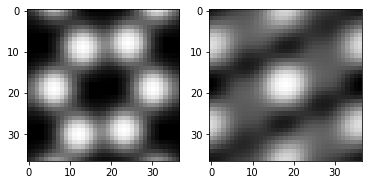

In [ ]:
img_stack.shape
fig,ax=plt.subplots(1,2)
ax[0].imshow(img_stack_init[100,:,:])
ax[1].imshow(img_stack[100,:,:])

dimension reduction using PCA

In [ ]:
img_stack_flat=img_stack.reshape(img_stack.shape[0],img_stack.shape[1]*img_stack.shape[2])
img_stack_flat.shape

(44918, 1369)

In [ ]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(img_stack_flat[:,:])              
# pca.fit(img_stack_init_flat[:,:])
explained_var = pca.explained_variance_ratio_
sum=0
nc=0
i=0
while sum<0.95:
    print(str(i+1)+'th component accounts for:'+str(explained_var[i]))
    sum=sum+explained_var[i]
    nc=nc+1
    i=i+1
print(str(nc)+'components can explain'+str(sum)+'of the behavior')

NC=nc
pca = PCA(n_components=NC)
X_vec_t = pca.fit_transform(img_stack_flat[:,:])
components = pca.components_

print('shape of the components is')
print(components.shape)
print(X_vec_t.shape)

1th component accounts for:0.6339382390854386
2th component accounts for:0.16929376974595922
3th component accounts for:0.11321298118993393
4th component accounts for:0.026260317403891682
5th component accounts for:0.01554935919633413
5components can explain0.9582546666215576of the behavior
shape of the components is
(5, 1369)
(44918, 5)


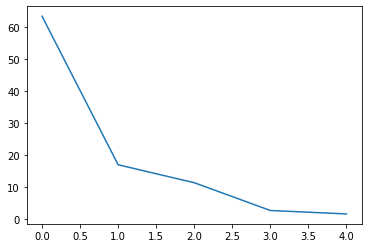

In [ ]:
plt.plot(100*explained_var[:NC])

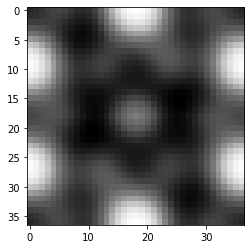

In [ ]:
plt.imshow(components.reshape(NC,img_stack.shape[1],img_stack.shape[2])[0,:,:])

In [ ]:
# nu_min=0.05
# nu_max=0.30
# nu_step=0.05
# #the number of nu i the horizontal direction
# nu_num=(nu_max-nu_min)/nu_step
# nu_num=int(nu_num)
# gamma_0=1/(X_vec_t.shape[1]*X_vec_t[:,:].var())
# gamma_ratios=np.arange(1,3,1)
# #the number of gamma
# gamma_num=len(gamma_ratios)

# Dvs=np.zeros((gamma_num,nu_num))

# for j,gamma_ratio in enumerate(gamma_ratios):
#    for i, nu in enumerate(np.arange(nu_min,nu_max,nu_step)):
#       clf=OneClassSVM(gamma=gamma_ratio*gamma_0,nu=nu,max_iter=-1).fit(X_vec_t)
#       decision_f=clf.decision_function(X_vec_t)
#       P1=np.median(decision_f[np.where(decision_f<=0)])
#       P2=np.median(decision_f[np.where(decision_f>0)])
#       Dv=(P2-P1)/(decision_f.max()-decision_f.min())
#       Dvs[j,i]=Dv
    

# plt.plot(np.arange(nu_min,nu_max,nu_step),Dvs[1,:])
# plt.xlabel('The nu parameter')
# plt.ylabel('D(v)')

In [ ]:
# plt.plot(np.arange(gamma_ratios.min(),gamma_ratios.max(),1),Dvs[:,2])
# plt.xlabel('The gamma parameter')
# plt.ylabel('D(v)')

In [ ]:
# ratio_rank=0
# plt.plot(np.arange(nu_min,nu_max,nu_step),Dvs[ratio_rank,:])
# plt.xlabel(r'$\nu$')
# plt.ylabel('D('r'$\nu$'')')
# plt.xlim(0.0,0.3)
# plt.minorticks_on()
# plt.ylim(0,1)
# print(gamma_ratios[ratio_rank])

For this dataset gamma_ratio=10, nu=0.1-0.2 is a good choice

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
6


(array([  21.,   22.,   22.,   18.,   16.,   21.,   22.,   26.,   21.,
          22.,   32.,   22.,   23.,   25.,   28.,   20.,   27.,   12.,
          20.,   21.,   22.,   21.,   21.,   31.,   32.,   20.,   30.,
          31.,   22.,   33.,   27.,   17.,   37.,   36.,   35.,   24.,
          39.,   31.,   26.,   29.,   30.,   30.,   32.,   43.,   23.,
          33.,   31.,   39.,   45.,   43.,   35.,   35.,   38.,   46.,
          54.,   53.,   60.,   70.,   53.,   60.,   65.,   61.,   65.,
          92.,   75.,   81.,  102.,   99.,  110.,  122.,  125.,  130.,
         172.,  177.,  210.,  240.,  293.,  720.,  479.,  550.,  640.,
         803.,  898., 1032., 1261., 1557., 1834., 2147., 2490., 2966.,
        3182., 3642., 3994., 4486., 3846., 2420., 1237.,  489.,  137.,
          31.]), array([-31.91838798, -31.50751859, -31.09664921, -30.68577982,
        -30.27491044, -29.86404105, -29.45317167, -29.04230228,
        -28.6314329 , -28.22056352, -27.80969413, -27.39882475,
        -26

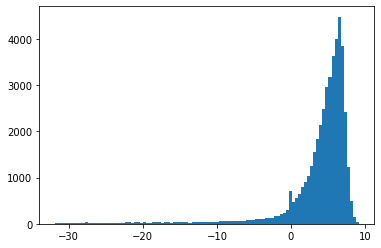

In [ ]:
from sklearn.svm import OneClassSVM

gamma_0=1/(X_vec_t.shape[1]*X_vec_t[:,:].var())
gamma_ratios=np.arange(1,101,1)
print(gamma_ratios)
ratio_rank=5
print(gamma_ratios[ratio_rank])

clf=OneClassSVM(gamma=gamma_ratios[ratio_rank]*gamma_0,nu=0.10,max_iter=-1).fit(X_vec_t[:,:])
cate=clf.predict(X_vec_t[:,:])
decision_f=clf.decision_function(X_vec_t[:,:])
scores=clf.score_samples(X_vec_t[:,:])
score_tot=np.sum(scores)
plt.hist(decision_f,bins=100)
# plt.xlim(-1000,1000)

In [ ]:
# from sklearn.svm import OneClassSVM

# gamma_0=1/(X_vec_t.shape[1]*X_vec_t[:,:].var())
# gamma_ratios=np.arange(1,11,1)
# print(gamma_ratios)
# ratio_rank=0
# print(gamma_ratios[ratio_rank])

# clf=OneClassSVM(gamma=gamma_ratios[ratio_rank]*gamma_0,nu=0.1,max_iter=-1).fit(X_vec_t[:,:])
# cate=clf.predict(X_vec_t[:,:])
# decision_f=clf.decision_function(X_vec_t[:,:])
# scores=clf.score_samples(X_vec_t[:,:])
# score_tot=np.sum(scores)
# plt.hist(decision_f,bins=100)
# # plt.xlim(-1000,1000)

In [ ]:
color_outlier=np.zeros((img_stack_flat.shape[0]))
for i in range(color_outlier.shape[0]):
  if cate[i]==1:
    color_outlier[i]=1
  if cate[i]==-1:
    color_outlier[i]=-1


In [ ]:
# color_outlier=np.zeros((img_stack_flat.shape[0]))
# for i in range(color_outlier.shape[0]):
#   if decision_f[i]>0: #and decision_f[i]>0:
#     color_outlier[i]=1
#   else:
#     color_outlier[i]=-1

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 32}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


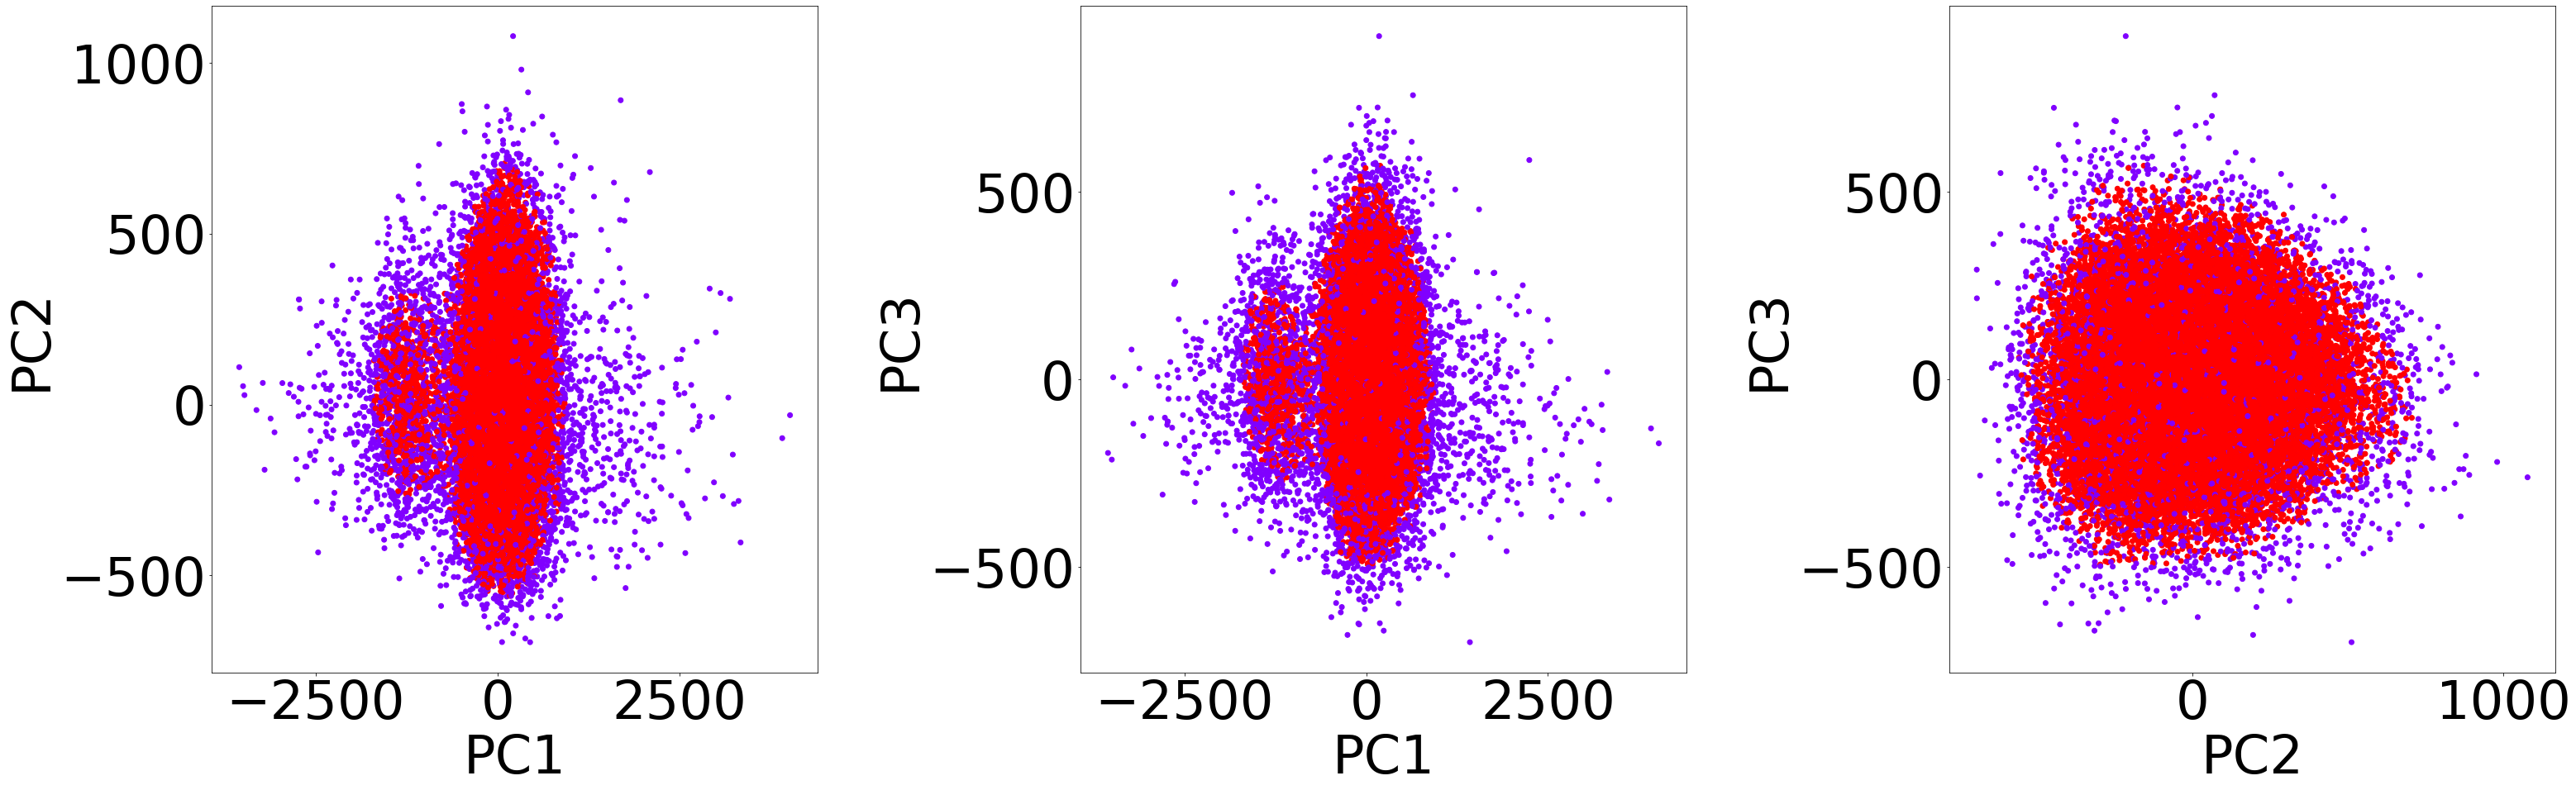

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(45,15))
plt.set_cmap('rainbow')


ax[0].scatter(X_vec_t[:,0],X_vec_t[:,1],c=color_outlier)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].scatter(X_vec_t[:,0],X_vec_t[:,2],c=color_outlier)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC3')

ax[2].scatter(X_vec_t[:,1],X_vec_t[:,2],c=color_outlier)
ax[2].set_xlabel('PC2')
ax[2].set_ylabel('PC3')

plt.tight_layout(h_pad=2)

In [ ]:
from sklearn.mixture import GaussianMixture

n_components=2

gmmp = GaussianMixture(n_components=n_components,covariance_type='full',
                           random_state=1090) #diag,'full', ‘tied’, ‘diag’, ‘spherical’
gmm_zp = gmmp.fit_predict(X_vec_t[:,:]) # predicting the labels for each vector
clf_1=gmmp.fit(X_vec_t[:,:])

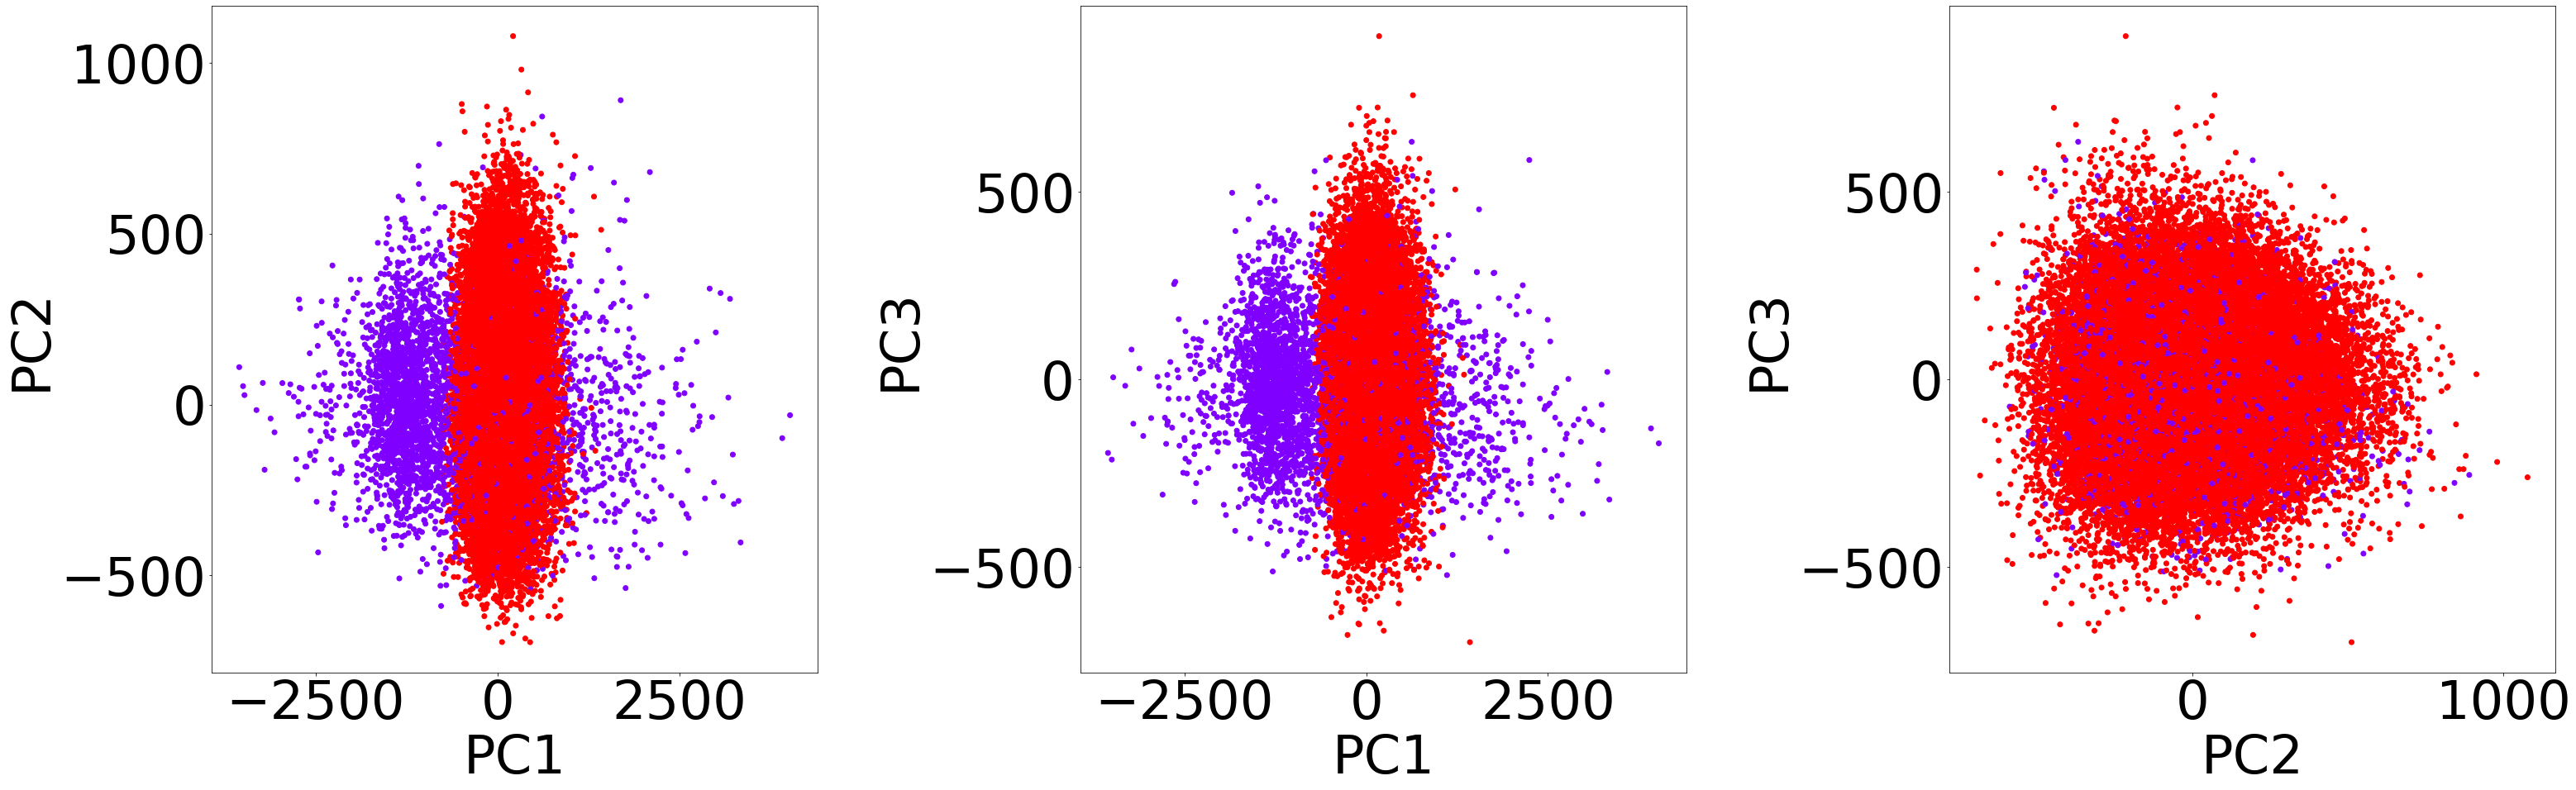

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(45,15))
plt.set_cmap('rainbow')


ax[0].scatter(X_vec_t[:,0],X_vec_t[:,1],c=gmm_zp[:])
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].scatter(X_vec_t[:,0],X_vec_t[:,2],c=gmm_zp[:])
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC3')

ax[2].scatter(X_vec_t[:,1],X_vec_t[:,2],c=gmm_zp[:])
ax[2].set_xlabel('PC2')
ax[2].set_ylabel('PC3')

plt.tight_layout(h_pad=2)

In [ ]:
gmm_zp.shape

(44918,)

(array([ 3598.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 41320.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

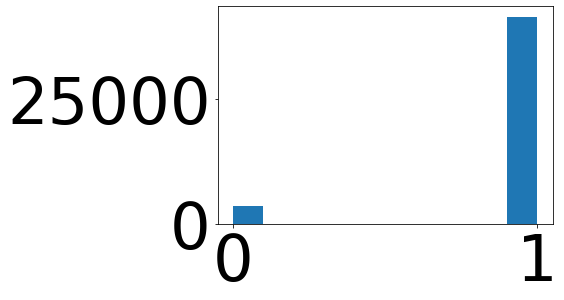

In [ ]:
plt.hist(gmm_zp)

In [ ]:
print(scores[np.where(color_outlier==-1)].shape[0]/scores.shape[0])

0.10011576650785876


In [ ]:
new_coord_collection.shape

(44918, 3)

In [ ]:
cate.shape

(44918,)

In [ ]:
outlier_coord=np.zeros((cate.shape[0],4))

# frame, cate,row,col

for i in np.arange(cate.shape[0]):
   outlier_coord[i,0]=new_coord_collection[i,0]
   outlier_coord[i,1]=cate[i]
   outlier_coord[i,2]=new_coord_collection[i,1]
   outlier_coord[i,3]=new_coord_collection[i,2]


## Result with only OCSVM

In [ ]:
def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(semantic_image[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
  plt.scatter(outlier_coord[np.where((outlier_coord[:,0]==i)&(outlier_coord[:,1]==-1))][:,3],outlier_coord[np.where((outlier_coord[:,0]==i)&(outlier_coord[:,1]==-1))][:,2],c='r')
  plt.axis('off')

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

In [ ]:
xy_refined.shape

(65301, 3)

In [ ]:
new_coord_collection

array([[  0., 464., 205.],
       [  0., 463.,  96.],
       [  0., 464., 168.],
       ...,
       [ 99.,  49., 133.],
       [ 99.,  50., 352.],
       [ 99.,  49.,  96.]])

Results with only GMM

In [ ]:
def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(semantic_image[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
  plt.scatter(new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,2],new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,1],c='r')
  # plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
  plt.axis('off')

interactive_plot = interactive(F, i=(0, nth_frame))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

Clean the X_vec_t[:,:] by removing the small group and carry out OCSVM afterwards

In [ ]:
X_vec_t[:,:][np.where(gmm_zp==1)].shape

(41320, 5)

In [ ]:
X_vec_t[:,:][np.where(gmm_zp==0)].shape

(3598, 5)

In [ ]:
X_vec_t_2=X_vec_t[:,:][np.where(gmm_zp==1)]
print(X_vec_t_2.shape)

(41320, 5)


In [ ]:
new_coord_collection_2=new_coord_collection[:,:][np.where(gmm_zp==1)]
new_coord_collection_2.shape

(41320, 3)

Now carry out OCSVM on this group

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
6


(array([2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 1.000e+00,
        4.000e+00, 5.000e+00, 9.000e+00, 4.000e+00, 9.000e+00, 7.000e+00,
        3.000e+00, 8.000e+00, 1.200e+01, 6.000e+00, 8.000e+00, 8.000e+00,
        5.000e+00, 1.000e+01, 8.000e+00, 8.000e+00, 1.300e+01, 1.200e+01,
        1.500e+01, 1.800e+01, 1.300e+01, 1.700e+01, 2.500e+01, 2.300e+01,
        2.500e+01, 3.400e+01, 2.800e+01, 4.400e+01, 3.700e+01, 1.267e+03,
        2.730e+02, 3.450e+02, 4.270e+02, 4.610e+02, 5.490e+02, 6.780e+02,
        8.360e+02, 1.014e+03, 1.246e+03, 1.493e+03, 1.963e+03, 2.485e+03,
        3.147e+03, 3.829e+03, 4.441e+0

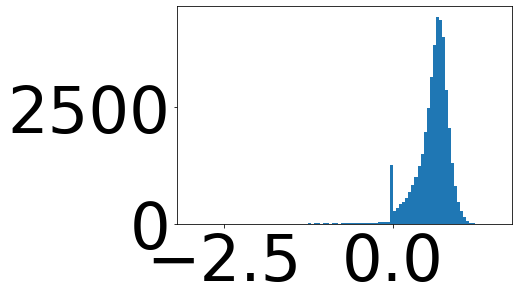

In [ ]:
from sklearn.svm import OneClassSVM

gamma_0=1/(X_vec_t_2.shape[1]*X_vec_t_2[:,:].var()) # same as 'scale' in the default
gamma_ratios=np.arange(1,101,1)
print(gamma_ratios)
ratio_rank=5
print(gamma_ratios[ratio_rank])

clf_2=OneClassSVM(gamma=gamma_ratios[ratio_rank]*gamma_0,nu=0.025,max_iter=-1).fit(X_vec_t_2[:,:])
cate_2=clf_2.predict(X_vec_t_2[:,:])
decision_f_2=clf_2.decision_function(X_vec_t_2[:,:])
# scores=clf_2.score_samples(X_vec_t_2[:,:])
# score_tot=np.sum(scores)
plt.hist(decision_f_2,bins=100)
# plt.xlim(-1000,1000)

In [ ]:
color_outlier_2=np.zeros((X_vec_t_2.shape[0]))
for i in range(color_outlier_2.shape[0]):
  if cate_2[i]==1:
    color_outlier_2[i]=1
  if cate_2[i]==-1:
    color_outlier_2[i]=-1


In [ ]:
outlier_coord_2=np.zeros((cate_2.shape[0],4))

# frame, cate,row,col

for i in np.arange(cate_2.shape[0]):
   outlier_coord_2[i,0]=new_coord_collection_2[i,0]
   outlier_coord_2[i,1]=cate_2[i]
   outlier_coord_2[i,2]=new_coord_collection_2[i,1]
   outlier_coord_2[i,3]=new_coord_collection_2[i,2]


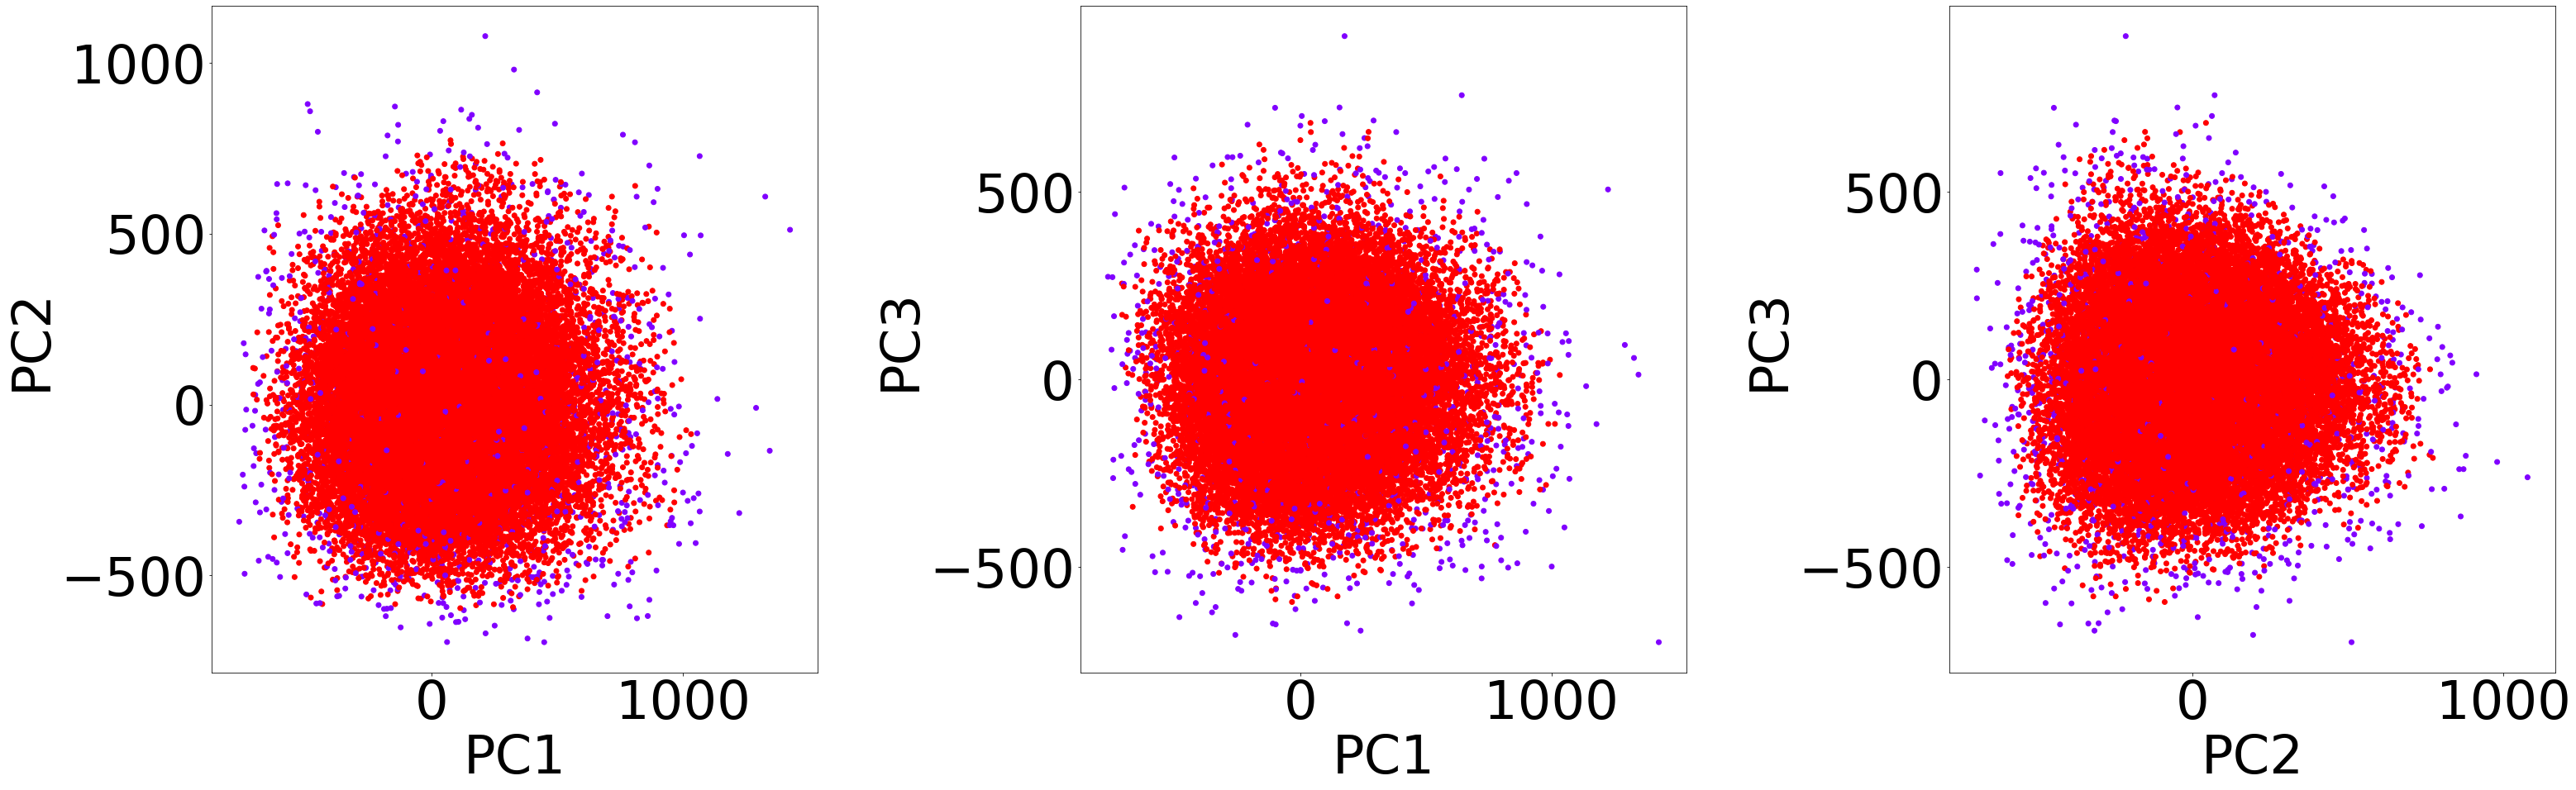

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(45,15))
plt.set_cmap('rainbow')


ax[0].scatter(X_vec_t_2[:,0],X_vec_t_2[:,1],c=color_outlier_2)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].scatter(X_vec_t_2[:,0],X_vec_t_2[:,2],c=color_outlier_2)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC3')

ax[2].scatter(X_vec_t_2[:,1],X_vec_t_2[:,2],c=color_outlier_2)
ax[2].set_xlabel('PC2')
ax[2].set_ylabel('PC3')

plt.tight_layout(h_pad=2)

In [ ]:
def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(semantic_image[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  # Blue:all the sites/datapoints that have been included in the training set
  plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
 
  # Orange: the sites that have been identified by the OCSVM after GMM
  plt.scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')
   # Red: The sites that have been cleaned up by GMM
  plt.scatter(new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,2],new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,1],c='r')
  # plt.scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')

  # plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
  plt.axis('off')

interactive_plot = interactive(F, i=(0, nth_frame-1))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [ ]:
def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(YG_data_norm[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  # Blue:all the sites/datapoints that have been included in the training set
  plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
 
  # Orange: the sites that have been identified by the OCSVM after GMM
  plt.scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')
   # Red: The sites that have been cleaned up by GMM
  plt.scatter(new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,2],new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,1],c='r')
  # plt.scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')

  # plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
  plt.axis('off')

interactive_plot = interactive(F, i=(0, nth_frame-1))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [ ]:
def F(i):
  plt.figure(figsize=(10,10))
  plt.imshow(data[i,:,:],cmap='gray')
  # Blue:all the sites/datapoints that have been included in the training set
  plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
 
  # Orange: the sites that have been identified by the OCSVM after GMM
  plt.scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')
   # Red: The sites that have been cleaned up by GMM
  plt.scatter(new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,2],new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,1],c='r')
  # plt.scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')

  # plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
  plt.axis('off')

interactive_plot = interactive(F, i=(0, nth_frame-1))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

Count the percentage of defect sites

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


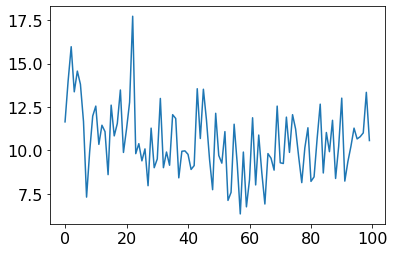

In [ ]:
defect_percent=np.zeros((100))
num_of_defects=np.zeros((100))
for i in np.arange(YG_data.shape[0]):
   blue=new_coord_collection[np.where(new_coord_collection[:,0]==i)].shape[0]
   red=new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))].shape[0]
   orange=new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))].shape[0]
   defect_percent[i]=100*(red+orange)/blue
   num_of_defects[i]=(red+orange)

plt.plot(defect_percent)


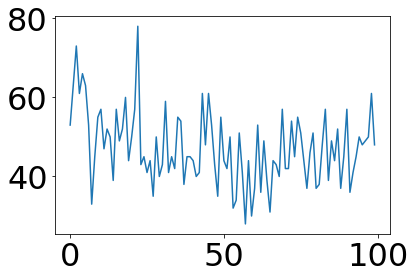

In [ ]:
plt.plot(num_of_defects)

In [ ]:
def F(i):
  fig,ax = plt.subplots(1,2,figsize=(20,10))

  plt.figure(figsize=(10,20))
  ax[1].imshow(YG_data_norm[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  # Blue:all the sites/datapoints that have been included in the training set
  ax[1].scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
 
  # Orange: the sites that have been identified by the OCSVM after GMM
  ax[1].scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')
   # Red: The sites that have been cleaned up by GMM
  ax[1].scatter(new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,2],new_coord_collection[np.where((gmm_zp==0)&(new_coord_collection[:,0]==i))][:,1],c='r')
  # plt.scatter(new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,2],new_coord_collection_2[np.where((cate_2==-1)&(new_coord_collection_2[:,0]==i))][:,1],c='orange')

  # plt.scatter(new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,2],new_coord_collection[np.where(new_coord_collection[:,0]==i)][:,1],c='b')
  ax[1].axis('off')
  ax[0].imshow(YG_data_norm[i,:,:],cmap='gray',vmax=1,vmin=0.0)
  ax[0].axis('off')

interactive_plot = interactive(F, i=(0, nth_frame-1))
# output=interactive_plot.children[-1]
#output.layout.height='256px'
interactive_plot

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [ ]:
import pickle
pickle.dump(fig, open('Defect_detection_img_stack.fig.pickle', 'wb'))

In [ ]:
import pickle
figxx = pickle.load(open('/content/Defect_detection_img_stack.fig.pickle', 'rb'))

# figx.show() # Show the figure, edit it, etc.!